# Goal
Hypothesis: template tweets are quite insular. Find the nearest neighbor in the embedded space for all tweets. How many of template tweets neighbors are other template tweets? Non-template tweets? etc. 

### Steps 
1. For a hashtag, get unique tweets. Only take 1 of the template tweets. Only take root nodes. 
2. Generate sentence embeddings
3. For each tweet, find the k nearest neighbors in the space. Compare how they breakdown, normalizing by number of template/non-template in the given hashtag.

In [1]:
import preprocessing

In [2]:
campaigns = preprocessing.load_campaign()

In [21]:
ht = 'jharkhandwithmodi'
campaign = campaigns[ht]

In [8]:
list(campaign.values())[:10]

[{'username': 'gajendar_bjp',
  'id': '1095229661829873669',
  'retweet_from': 'kishanreddybjp',
  'template': '',
  'retweet_id': '1095194764918419456',
  'text': "rt @kishanreddybjp: hoisted @bjp4india flag at my home along with friends, well-wishers and party colleagues today as part of #meraparivarbhajapaparivar campaign. 5 crore bjp workers and well wishers across the country will put up bjp's flag at their homes as part of the campaign. #bjp4telangana https://t.co/ggft1wp84d",
  'date': datetime.datetime(2019, 2, 12, 7, 54, 34),
  'retweets': 345,
  'favorites': 0},
 {'username': 'sureshklatiyal',
  'id': '1095673888451702785',
  'retweet_from': 'malikrosyanand',
  'template': '',
  'retweet_id': '1095633312519995397',
  'text': "rt @malikrosyanand: #meraparivarbhajapaparivar के अंतर्गत आज मैंने अपने घर पर भाजपा का झंडा लगाकर 'फिर एक बार- मोदी सरकार' का संकल्प लिया। क्या आपने यह कार्य किया ?? #malikrosyanand #victory2019 #bjpharyana https://t.co/1stqxo7hri",
  'date': datetime.da

### Processing Unique Tweets

In [22]:
unique_tweets = []
templates = []
n_templates = 0
for tweet in campaign.values():
    if tweet['template'] != '':
        n_templates += 1
        if  tweet['template'] not in templates:
            unique_tweets.append(tweet)
            templates.append(tweet['template'])
    if tweet['retweet_id'] == '': # root tweet
        unique_tweets.append(tweet)
        
# remove duplicate templates

In [23]:
print('number of unique tweets', len(unique_tweets))
print('number of unique templates', len(templates))
print('number of total templates', n_templates)

number of unique tweets 7429
number of unique templates 219
number of total templates 2865


## Embeddings

In [24]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [25]:
corpus_embeddings = model.encode([x['text'] for x in unique_tweets])

## Basic Visualization by PC

In [27]:
from sklearn.decomposition import PCA
import numpy as np
X_sbert = np.vstack(corpus_embeddings).T

pca_transform = PCA(n_components=2)
transformed_data = pca_transform.fit_transform(X_sbert.T)



In [40]:
print('explained varianced of first two PCs', sum(pca_transform.explained_variance_ratio_))

explained varianced of first two PCs 0.17071401327848434


Text(0, 0.5, 'PC2')

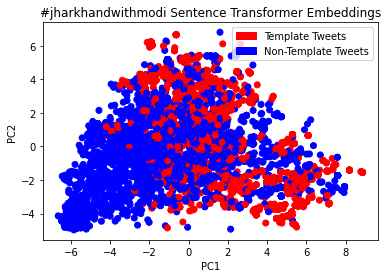

In [155]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
colors = ['b' if x['template'] == '' else 'r' for x in unique_tweets ]
plt.scatter(transformed_data[:,0], transformed_data[:, 1], color=colors)
plt.legend(handles=[mpatches.Patch(color='red', label='Template Tweets'), 
            mpatches.Patch(color='blue', label='Non-Template Tweets')])
plt.title("#jharkhandwithmodi Sentence Transformer Embeddings")
plt.xlabel('PC1')
plt.ylabel('PC2')

In [31]:
transformed_data[:,1].shape

(7429,)

## Finding Nearest Neighbors

In [128]:
from sklearn.neighbors import NearestNeighbors
N_NEIGHBORS = 100
nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm='ball_tree').fit(X_sbert.T)

In [129]:
distances, indices = nbrs.kneighbors(X_sbert.T)

In [145]:
templates, normals = [], []
for i, tweet in enumerate(unique_tweets):
    neighbors = indices[i, :]
    tweet_type = 'template' if tweet['template'] != '' else 'normal'
    neighbor_tweets = np.array(unique_tweets)[neighbors]
    n_template = len([x for x in neighbor_tweets if x['template'] != ''])
    if tweet['template'] != '':
        templates.append(n_template)
    else:
        normals.append(n_template)

## Normalizing
Need to normalize by prevalence in the dataset

I should just plot % template and then also plot a line that shows the dataset % template


In [131]:
global_pct_temp = len(templates)/len(unique_tweets)

In [153]:
.35*.74 + .65*.19

0.3825

average % template of template neighbors 0.7374741676234213
average % template of normal neighbors 0.19187707641196014
% of tweets that are templates 0.35172970790146724


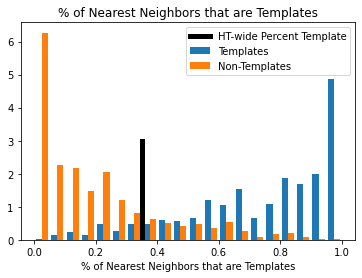

In [161]:
temp_pcts = np.array(templates)/N_NEIGHBORS
norm_pcts = np.array(normals)/N_NEIGHBORS
plt.hist([temp_pcts, norm_pcts], label=['Templates', 'Non-Templates'], bins=20, density=True)
plt.plot([global_pct_temp, global_pct_temp], [0,3], 'black', label='HT-wide Percent Template', linewidth=5, markersize=50)
plt.legend()
plt.title('% of Nearest Neighbors that are Templates')
plt.xlabel('% of Nearest Neighbors that are Templates')

print('average % template of template neighbors', np.mean(temp_pcts))
print('average % template of normal neighbors', np.mean(norm_pcts))
print('% of tweets that are templates', np.mean(global_pct_temp))

## Creating a Script to run on all submessages

In [154]:
100/len(unique_tweets)

0.013460761879122358

In [1]:
import preprocessing
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
campaigns = preprocessing.load_campaign()
result_dict = {}
embeddings_dict = {}
for ht, campaign in campaigns.items():
    result = {}
    unique_tweets = []
    templates = []
    n_templates = 0
    for tweet in campaign.values():
        if tweet['template'] != '':
            n_templates += 1
            if  tweet['template'] not in templates:
                unique_tweets.append(tweet)
                templates.append(tweet['template'])
        if tweet['retweet_id'] == '': # root tweet
            unique_tweets.append(tweet)
        result['unique_tweets'] = unique_tweets
        result['len_unique_tweets'] = len(unique_tweets)
        result['len_unique_templates'] =  len(templates)
        result['len_total_templates'] = n_templates
            
    model = SentenceTransformer('xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
    corpus_embeddings = model.encode([x['text'] for x in unique_tweets])
    embeddings_dict[ht] = corpus_embeddings

    X_sbert = np.vstack(corpus_embeddings).T
    N_NEIGHBORS = round(len(unique_tweets)/20) # search 5%
    result['n_neighbors'] = N_NEIGHBORS
    nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm='ball_tree').fit(X_sbert.T)
    distances, indices = nbrs.kneighbors(X_sbert.T)    
    templates, normals = [], []
    for i, tweet in enumerate(unique_tweets):
        neighbors = indices[i, :]
        tweet_type = 'template' if tweet['template'] != '' else 'normal'
        neighbor_tweets = np.array(unique_tweets)[neighbors]
        n_template = len([x for x in neighbor_tweets if x['template'] != ''])
        if tweet['template'] != '':
            templates.append(n_template)
        else:
            normals.append(n_template)
            
    result['template_n_template_neighbors'] = templates
    result['normal_n_template_neighbors'] = normals
    
    global_pct_temp = len(templates)/len(unique_tweets)    
    result['global_pct_temp'] = global_pct_temp

## FAISS

In [41]:
! module load cuda/9.0

init.c(556):ERROR:161: Cannot initialize TCL


In [43]:
import sys
!conda install --yes --prefix {sys.prefix} faiss-cpu -c pytorch
#!conda install --yes --prefix {sys.prefix} faiss-gpu cudatoolkit=9.0 -c pytorch # For CUDA9

Fetching package metadata ...........
Solving package specifications: .

UnsatisfiableError: The following specifications were found to be in conflict:
  - faiss-cpu -> libgcc -> _libgcc_mutex * free
  - faiss-cpu -> python >=3.6,<3.7.0a0 -> openssl 1.0.2*
  - faiss-cpu -> python >=3.6,<3.7.0a0 -> readline 6.2
  - faiss-cpu -> python >=3.6,<3.7.0a0 -> sqlite 3.13.*
  - faiss-cpu -> python >=3.6,<3.7.0a0 -> tk 8.5.18
  - python 3.8*
Use "conda info <package>" to see the dependencies for each package.

